# Notebook 2B. Time Series Forecasting using RNN
---
Organized and prepared by Christopher Monterola, updated by Kenneth Co.

This notebook was conceptualized, organized, and primarily prepared for the **Machine Learning** courses.

### This notebook uses the following references:
1. Python Machine Learning, Second Edition, Sebastian Raschka and Vahid Mirjalili, Packt Publishing Ltd. Birmingham B3 2PB, UK Sept 2017.
2. Hands-On Machine Learning with Scikit-Learn and TensorFlow, Aurélien Géron, O'Reilly 2017.
3. Deep Learning with Python, Francois Chollet, Manning New York 2018.

---
In this notebook, we will continue in illustrating RNN by using it to  work on the following: **Temperature forecasting problem**.

## Google Colab Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DATA_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/data/'
IMG_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/images/'
MODEL_DIR = '/content/drive/MyDrive/COSCI224 Machine Learning 3 Notebooks/models/'

# DATA_DIR = 'data/'
# IMG_DIR = 'images/'
# MODEL_DIR = 'models/'

Mounted at /content/drive


First, enable GPUs for the notebook:

- Navigate to ```Edit → Notebook Settings``` in the toolbar
- Select ```GPU``` or ```TPU```from the Hardware Accelerator drop-down

Next, verify if GPU or TPU is enabled. You will know this by running the code script below. It should show that a GPU is recognized.

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In the next example, we’ll review three advanced techniques for improving the performance and generalization power of recurrent neural networks.  We’ll demonstrate all three concepts on a temperature-forecasting problem, where you have access to a timeseries of data points coming from sensors installed on the roof of a building, such as temperature, air pressure, and humidity, which you use to predict what the temperature will be 24 hours after the last data point.

This is a fairly challenging problem that exemplifies many common difficulties encountered when working with timeseries. We’ll cover the following techniques:
- GRU based architecture in contrast with simple RNN and LSTM    
- Recurrent dropout—This is a specific, built-in way to use dropout to fight overfitting in recurrent layers.    
- Stacking recurrent layers—This increases the representational power of the network (at the cost of higher computational loads).    

# Example 2: Temperature Forecasting
---

Sequence data is found in diverse problems other than just language processing. In all the examples in this section, you’ll play with a weather timeseries dataset recorded at the Weather Station at the Max Planck Institute for Biogeochemistry in Jena, Germany.

In this dataset, 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. The original data goes back to 2003, but this example is limited to data from 2009–2016. This dataset is perfect for learning to work with numerical timeseries. You’ll use it to build a model that takes as input some data from the recent past (a few days’ worth of data points) and predicts the air temperature 24 hours in the future.

Here are the actual variables in the data:
* Date Time   
* p (mbar) atmospheric pressure  
* T (degC) temperature  
* Tpot (K) potential temperature  
* Tdew (degC) dew point temperature  
* rh (%) relative humidity  
* VPmax (mbar) saturation water vapor pressure  
* VPact (mbar) actual water vapor pressure  
* VPdef (mbar) water vapor pressure deficit  
* sh (g/kg) specific humidity  
* H2OC (mmol/mol) water vapor concentration  
* rho (g/$m^3$) air density  
* wv (m/s) wind velocity  
* max. wv (m/s) maximum wind velocity  
* wd (deg) wind direction  


## Step 1. Get the data

Download and uncompress the data as follows:

### Inspecting the data of the Jena weather dataset

In [ ]:
import os, shutil

from google.colab import drive
drive.mount('/content/drive')

data_dir = '/content/drive/MyDrive/Teaching/ML3_MSDS2024FT/Notebook 2B/'

Mounted at /content/drive


In [ ]:
import os

fname = DATA_DIR + 'jena_climate_2009_2016.csv'
f = open(fname)
data = f.read()
f.close()
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420551


In [ ]:
import pandas as pd

data2 = pd.read_csv(DATA_DIR + 'jena_climate_2009_2016.csv')
dummy=data2
dummy.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


Now, convert all 420,551 lines of data into a Numpy array.

In [ ]:
import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [ ]:
float_data.shape

(420551, 14)

## Step 2. Visualize by plotting the temperature timeseries

You can clearly see the yearly periodicity of temperature.

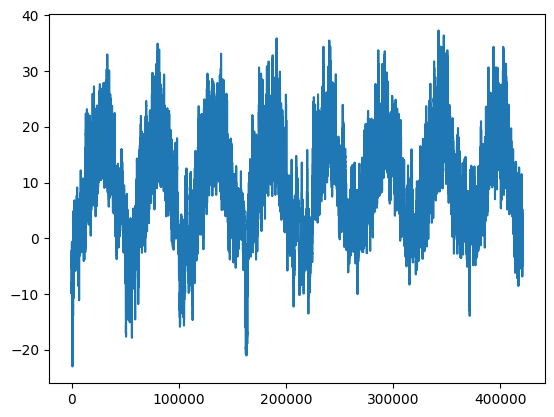

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

temp = float_data[:, 1]  #temperature (in degrees Celsius)
plt.plot(range(len(temp)), temp)

Below is a more narrow plot of the first 10 days of temperature data or first 1440 data points. Because the data is recorded every 10 minutes, you get 144 data points daily.

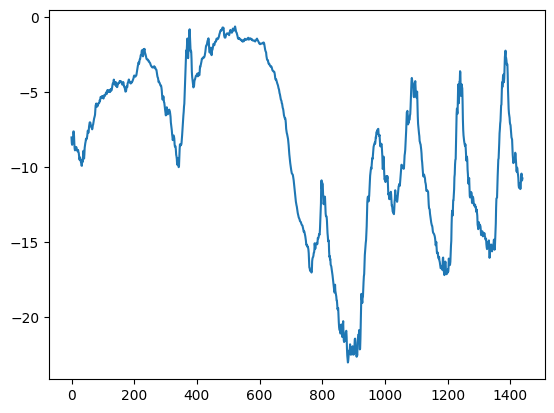

In [ ]:
plt.plot(range(1440), temp[:1440])

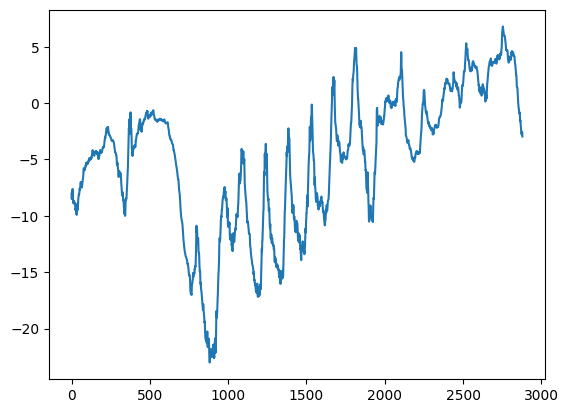

In [ ]:
plt.plot(range(2880), temp[:2880])

On this plot, you can see daily periodicity, especially evident for the last 4 days. Also note that this 10-day period must be coming from a fairly cold winter month. If you were trying to predict average temperature for the next month given a few months of past data, the problem would be easy, due to the reliable year-scale periodicity
of the data.

But looking at the data over a scale of days, the temperature looks a lot more chaotic. Is this timeseries predictable at a daily scale? Let’s find out. Shown below are plots for 100 days ($2880*5$) and 200 days ($2880*10$)

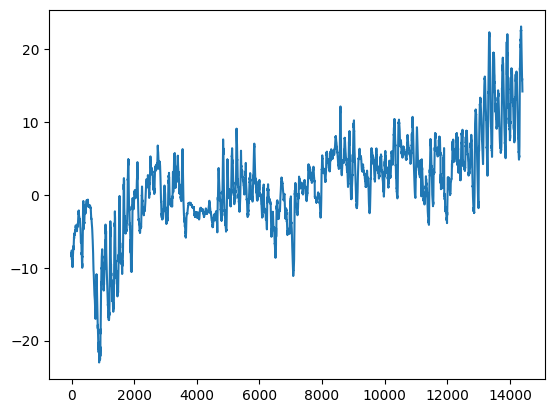

In [ ]:
plt.plot(range(2880*5), temp[:2880*5])

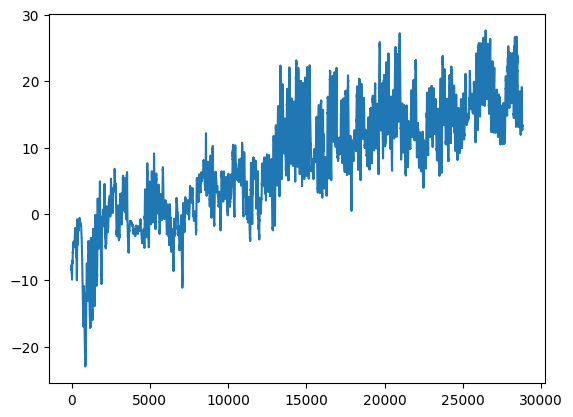

In [ ]:
plt.plot(range(2880*10), temp[:2880*10])

## Step 3. Preparing the data

The exact formulation of the problem will be as follows: given data going as far back as lookback timesteps (a timestep is 10 minutes) and sampled every steps timesteps, can you predict the temperature in delay timesteps?

You’ll use the following parameter values:

*  lookback = 1440—Observations will go back 10 days (10 days $\times$ 144
timesteps/day).   
*  steps = 6—Observations will be sampled at one data point per hour.   
*  delay = 144—Targets will be 24 hours in the future.   


<img width="1000" alt="FeedforwardNN_timeseries" src="https://user-images.githubusercontent.com/25600601/144736049-ebbb847e-a47f-4eab-8556-2ac9275b46f0.png">

<img width="1000" alt="RNNGRULSTM_timeseries" src="https://user-images.githubusercontent.com/25600601/144736075-aa23f072-f388-4d20-b268-63e741e6427c.png">


To get started, you need to do two things: **A. Normalization** and ** B. Sampling**

**A. Normalization**: Preprocess the data to a format a neural network can ingest. This is easy: the data is already numerical, so you don’t need to do any vectorization. But each time series in the data is on a different scale (for example, temperature is typically between -20 and +30 celsius, but atmospheric pressure, measured in mbar, is around 1,000). You’ll normalize each timeseries independently so that they all take small values on a similar scale.    

**B. Sampling**: Write a Python generator that takes the current array of float data and yields batches of data from the recent past, along with a target temperature in the future. Because the samples in the dataset are highly redundant (sample N and sample N + 1 will have most of their timesteps in common), it would be wasteful to explicitly allocate every sample. Instead, you’ll generate the samples on the fly using the original data.   

You’ll preprocess the data by subtracting the mean of each timeseries and dividing by the standard deviation.

*You’re going to use the first 200,000 timesteps as training data, so compute the mean and standard deviation only on this fraction of the data.*


### Step 3A. Normalize the data

In [ ]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean #ALL DATA BASED on theMEAN OF first 200k data points
std = float_data[:200000].std(axis=0)
float_data /= std #ALL DATA BASED on the STD OF first 200k data points

Listed in the code below are the data generator function you’ll use. It yields a tuple (samples, targets), where samples is one batch of input data and targets is the corresponding array of target temperatures. It takes the following arguments:
    
* **data**—The original array of floating-point data, which you normalized above.  
* **lookback**—How many timesteps back the input data should go.  
* **delay**—How many timesteps in the future the target should be.  
* **min_index** and **max_index**—Indices in the data array that delimit which timesteps to draw from. This is useful for keeping a segment of the data for validation and another for testing.  
* **shuffle**—Whether to shuffle the samples or draw them in chronological order.  
* **batch_size**—The number of samples per batch.  
* **step**—The period, in timesteps, at which you sample data. You’ll set it to 6 in order to draw one data point every hour. note that the number of inputs = lookback/step  

### Step 3B. Sampling the data
Generator yielding time series samples and their targets

In [ ]:
import numpy as np

def generator(data, lookback, delay, min_index, max_index, shuffle=False, batch_size=128, step=6):
    # Set default max_index if not provided
    if max_index is None:
        max_index = len(data) - delay - 1

    # Start index for data sampling
    i = min_index + lookback

    # Infinite loop to generate samples indefinitely
    while True:
        # Shuffle data if required; otherwise, generate sequential batches
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback  # Reset index if it goes beyond the max index
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)

        # Initialize numpy arrays to store samples and targets
        samples = np.zeros((len(rows), lookback // step, data.shape[-1]))
        targets = np.zeros((len(rows),))

        # Populate samples and targets arrays
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)  # Select indices for sample
            samples[j] = data[indices]  # Assign the sliced data to samples
            targets[j] = data[rows[j] + delay][1]  # Set the corresponding target

        # Yield a batch of samples and targets
        yield samples, targets


### Step 3C. Preparing the training, validation, and test generation

In [ ]:
lookback = 1440
step = 6
delay = 144*2
batch_size = 128 #Each of the batch will have inputs = lookback/step (240 hours in this example) +  delay/step (24 hours)

train_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=0,
    max_index=200000,
    shuffle=True,
    step=step,
    batch_size=batch_size)

val_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=200001,
    max_index=300000,
    shuffle=False,
    step=step,
    batch_size=batch_size)

test_gen = generator(float_data,
    lookback=lookback,
    delay=delay,
    min_index=300001,
    max_index=None,
    step=step,
    batch_size=batch_size)

val_steps = (300000 - 200001 - lookback)  #How many steps to draw from val_gen in order to see the entire
                                          #validation set ---
                                         #This is normally a problem in keras so let's manually set this to just 1000
test_steps = (len(float_data) - 300001 - lookback)  #How many steps to draw from test_gen in order to see the
                                          #entire test set

<div class="alert alert-block alert-info">

## ⚠️ Sign Post ⚠️
Run the code until here, then you can proceed to any of the next steps without issues since you have already pre-processed the data.
</div>

## Step 4. Understand the baseline
Before you start using black-box deep-learning models to solve the temperatureprediction problem, let’s try a simple, common-sense approach. It will serve as a sanity check, and it will establish a baseline that you’ll have to beat in order to demonstrate the usefulness of more-advanced

### Baseline Error

Common-sense baselines can be useful when you’re approaching a new problem for which there is no known solution (yet). A classic example is that of unbalanced classification tasks, where some classes are much more common than others. If your dataset contains 90% instances of class A and 10% instances of class B, then a common-sense approach to
the classification task is to always predict “A” when presented with a new sample. Such a classifier is 90% accurate overall, and any learning-based approach should therefore beat this 90% score in order to demonstrate usefulness.

Sometimes, such elementary baselines can prove surprisingly hard to beat.   

In this case, the temperature timeseries can safely be assumed to be continuous (the temperatures tomorrow are likely to be close to the temperatures today) as well as periodical with a daily period. Thus a common-sense approach is to predict **that the temperature 24 hours from now will be equal to the temperature right now.**

*Today is essentially the same as yesterday.*

Let’s evaluate this approach, using the mean absolute error (MAE = $\sum_{i=1}^{N} \frac{|Theoretical_i - Actual_i|}{N} = \sum_{i=1}^{N} \frac{|error_i|}{N}$) metric: *np.mean(np.abs(preds - targets))*

In [ ]:
import numpy as np

def evaluate_naive_method():
    # Initialize a list to store the mean absolute errors (MAEs) of each batch.
    batch_maes = []

    # Loop over a number of steps defined by val_steps.
    # val_steps should be defined elsewhere in your code and represent the total number of evaluation steps or batches.
    for step in range(val_steps):
        # Retrieve the next batch of data from the validation generator.
        # val_gen should be an iterable (like a generator) that yields a tuple (samples, targets) on each iteration.
        samples, targets = next(val_gen)

        # Use the last temperature reading from the last timestep in each sample as the prediction.
        # This assumes that your data format in samples is (batch_size, timesteps, features)
        # and that feature index 1 corresponds to temperature measurements.
        preds = samples[:, -1, 1]

        # Calculate the mean absolute error (MAE) for the batch.
        # This is done by computing the absolute difference between predictions and true targets,
        # then taking the mean of these differences.
        mae = np.mean(np.abs(preds - targets))

        # Append the calculated MAE of the current batch to the list of batch MAEs.
        batch_maes.append(mae)

    # After processing all batches, compute the average of the MAEs to get a final performance metric.
    print(np.mean(batch_maes))

# Call the function to evaluate the naive method on your validation data.
evaluate_naive_method()

0.28969941979609765


In [ ]:
std[1]

8.85249908220462

This yields an MAE of 0.29. Because the temperature data has been normalized to be centered on 0 and have a standard deviation of 1, this number isn’t immediately interpretable. It translates to an average absolute error of 0.29 × temperature_std degrees Celsius: 2.57°C.

In [ ]:
celsius_mae = 0.29 * std[1]
celsius_mae

2.5672247338393395

That’s a fairly large average absolute error. Now the game is to use your knowledge of
deep learning to do better.

## Step 5. Model 1: Feedforward Neural Networks
In the same way that it’s useful to establish a common-sense baseline before trying machine-learning approaches, it’s useful to try simple, cheap machine-learning models (such as small, densely connected networks) before looking into complicated and computationally expensive models such as RNNs. This is the best way to make sure any
further complexity you throw at the problem is legitimate and delivers real benefits. The following listing shows a fully connected model that starts by flattening the data and then runs it through two Dense layers. Note the lack of activation function on the last Dense layer, which is typical for a regression problem. You use MAE as the loss.

Because you evaluate on the exact same data and with the exact same metric you did with the common-sense approach, the results will be directly comparable.

In [ ]:
val_steps

98559

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3360)              0         
                                                                 
 dense (Dense)               (None, 32)                107552    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 107585 (420.25 KB)
Trainable params: 107585 (420.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500, #ideally steps_per_epoch = TotalTrainingSamples / TrainingBatchSize
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=1000) #ideally validation_steps = TotalvalidationSamples / ValidationBatchSize

Epoch 1/20


<ipython-input-20-709ffd236ce0>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 10s 19ms/step - loss: 1.4711 - val_loss: 0.6694
Epoch 2/20
500/500 [==============================] - 8s 17ms/step - loss: 0.4620 - val_loss: 0.3605
Epoch 3/20
500/500 [==============================] - 9s 17ms/step - loss: 0.3007 - val_loss: 0.3045
Epoch 4/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2722 - val_loss: 0.3129
Epoch 5/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2552 - val_loss: 0.3077
Epoch 6/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2462 - val_loss: 0.3067
Epoch 7/20
500/500 [==============================] - 9s 18ms/step - loss: 0.2368 - val_loss: 0.3108
Epoch 8/20
500/500 [==============================] - 10s 19ms/step - loss: 0.2308 - val_loss: 0.3057
Epoch 9/20
500/500 [==============================] - 11s 22ms/step - loss: 0.2252 - val_loss: 0.3243
Epoch 10/20
500/500 [==============================] - 9s 17ms/step - loss: 0.2212 - val_loss: 0.36

Let’s display the loss curves for validation and training.

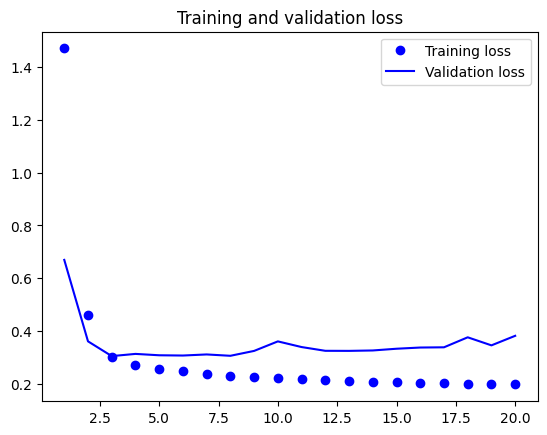

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

The lowest validation loss is **0.3045** close, but it failed to beat the no-learning baseline of **0.289**. This goes to show the merit of having this baseline in the first place: it turns out to be not easy to outperform. Your common sense contains a lot of valuable information that a machine-learning model doesn’t have access to.

You may wonder, if a simple, well-performing model exists to go from the data to the targets (the common-sense baseline), why doesn’t the model you’re training find it and improve on it? Because this simple solution isn’t what your training setup is looking for. The space of models in which you’re searching for a solution—that is, your hypothesis space—is the space of all possible two-layer networks with the configuration
you defined. These networks are already fairly complicated. When you’re looking for a solution with a space of complicated models, the simple, well-performing baseline may be unlearnable, even if it’s technically part of the hypothesis space.

That is a pretty significant limitation of machine learning in general: **unless the learning algorithm is hardcoded to look for a specific kind of simple model, parameter learning can sometimes fail to find a simple solution to a simple problem.**

## Step 6. Model 2: LSTM
We now test the LSTM model we learned in Notebook 2A.

In [ ]:
float_data.shape

(420551, 14)

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.LSTM(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                6016      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6049 (23.63 KB)
Trainable params: 6049 (23.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                                epochs=10,
                                validation_data=val_gen,
                                validation_steps=1000)

Epoch 1/10


<ipython-input-24-df7f30886ba7>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 69s 135ms/step - loss: 0.3017 - val_loss: 0.2716
Epoch 2/10
500/500 [==============================] - 80s 160ms/step - loss: 0.2737 - val_loss: 0.2704
Epoch 3/10
500/500 [==============================] - 80s 160ms/step - loss: 0.2638 - val_loss: 0.2699
Epoch 4/10
500/500 [==============================] - 82s 164ms/step - loss: 0.2537 - val_loss: 0.2714
Epoch 5/10
500/500 [==============================] - 80s 159ms/step - loss: 0.2455 - val_loss: 0.2773
Epoch 6/10
500/500 [==============================] - 78s 156ms/step - loss: 0.2387 - val_loss: 0.2858
Epoch 7/10
500/500 [==============================] - 77s 154ms/step - loss: 0.2334 - val_loss: 0.2967
Epoch 8/10
500/500 [==============================] - 79s 157ms/step - loss: 0.2270 - val_loss: 0.2940
Epoch 9/10
500/500 [==============================] - 76s 153ms/step - loss: 0.2227 - val_loss: 0.2916
Epoch 10/10
500/500 [==============================] - 78s 156ms/step - loss: 0.2157

The best result of **0.2699** beat the feedforward NN and the no learning baseline of **0.289** but clearly the model overfits.

## Step 7. Recurrent dropout to fight overfitting
It’s evident from the training and validation curves that the model is overfitting: the training and validation losses start to diverge considerably after a few epochs.

You’re already familiar with a classic technique for fighting this phenomenon: dropout, which randomly zeros out input units of a layer in order to break incidental correlations in the training data that the layer is exposed to. But how to correctly apply dropout in recurrent networks isn’t a trivial question. It has long been known that applying dropout before a recurrent layer hinders learning rather than helping with regularization. In 2015, Yarin Gal, as part of his PhD thesis on Bayesian deep learning, determined the proper way to use dropout with a recurrent network: the same dropout mask (the same pattern of dropped units) should be applied at every timestep, instead of a dropout mask that varies randomly from timestep to timestep.

What’s more, in order to regularize the representations formed by the recurrent gates of layers such as GRU and LSTM, a temporally constant dropout mask should be applied to the inner recurrent activations of the layer (a recurrent dropout mask). Using the same dropout mask at every timestep allows the network to properly propagate its learning error through time; a temporally random dropout mask would disrupt this error signal and be harmful to the learning process.

Yarin Gal did his research using Keras and helped build this mechanism directly into Keras recurrent layers (see Figure 1 below from https://becominghuman.ai/learning-note-dropout-in-recurrent-networks-part-1-57a9c19a2307). Every recurrent layer in Keras has two dropout-related arguments: dropout, a float specifying the dropout rate for input units of the layer, and recurrent_dropout, specifying the dropout rate of the recurrent units. Let’s add
dropout and recurrent dropout to the GRU layer and see how doing so impacts overfitting. Because networks being regularized with dropout always take longer to fully converge, you’ll train the network for twice as many epochs.


<img width="722" alt="dropouts" src="https://user-images.githubusercontent.com/25600601/144736347-2aa40588-a080-4f38-a868-8faf3f858a00.png">


Let's try and mitigate the overfitting using dropout.

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.LSTM(32, dropout=0.2,recurrent_dropout=0.2,input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 32)                6016      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6049 (23.63 KB)
Trainable params: 6049 (23.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                                epochs=5,
                                validation_data=val_gen,
                                validation_steps=1000)

Epoch 1/5


<ipython-input-26-b2658471bb3c>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 102s 199ms/step - loss: 0.3154 - val_loss: 0.2741
Epoch 2/5
500/500 [==============================] - 99s 199ms/step - loss: 0.2928 - val_loss: 0.2775
Epoch 3/5
500/500 [==============================] - 99s 199ms/step - loss: 0.2837 - val_loss: 0.2718
Epoch 4/5
500/500 [==============================] - 97s 193ms/step - loss: 0.2755 - val_loss: 0.2787
Epoch 5/5
500/500 [==============================] - 100s 199ms/step - loss: 0.2702 - val_loss: 0.2903


<div class="alert alert-block alert-info">

## ⚠️ Checkpoint ⚠️

In the next 10-15 minutes, try changing the following with your LT to see if you can improve on the MAE of 0.2699:
- Dropout
- Smaller/Bigger LSTM
</div>

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.LSTM(8, dropout=0.1,recurrent_dropout=0.1,input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 8)                 736       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 745 (2.91 KB)
Trainable params: 745 (2.91 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Step 8. Model 3: Gated Recurrent Unit (GRU)
Aside form the LSTM layer introduced in the previous lecture, we will implement also the GRU developed by Chung et al. in 2014.

The first fully connected approach didn’t do well, but that doesn’t mean machine learning isn’t applicable to this problem. The previous approach first flattened the timeseries, which removed the notion of time from the input data. Let’s instead look at the data as what it is: a sequence, where causality and order matter. You’ll try a recurrent-sequence processing model—it should be the perfect fit for such sequence data, precisely because it exploits the temporal ordering of data points, unlike the first approach. Gated recurrent unit (GRU) layers work using the same principle as LSTM, but they’re somewhat streamlined and thus cheaper to run (although they may not have as much representational power as
LSTM). This trade-off between computational expensiveness and representational power is seen everywhere in machine learning.  Note the dot in our previous figure is the $\times$ here.

![RNN_LSTMvsGRU](https://user-images.githubusercontent.com/25600601/144736256-f2a3e628-7b65-428b-8349-7f98c7e9d452.jpeg)

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                4608      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4641 (18.13 KB)
Trainable params: 4641 (18.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                                steps_per_epoch=500,
                                epochs=10,
                                validation_data=val_gen,
                                validation_steps=1000)

Epoch 1/10


<ipython-input-30-df7f30886ba7>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 67s 132ms/step - loss: 0.3093 - val_loss: 0.2715
Epoch 2/10
500/500 [==============================] - 69s 139ms/step - loss: 0.2872 - val_loss: 0.2715
Epoch 3/10
500/500 [==============================] - 67s 134ms/step - loss: 0.2800 - val_loss: 0.2646
Epoch 4/10
500/500 [==============================] - 72s 145ms/step - loss: 0.2759 - val_loss: 0.2654
Epoch 5/10
500/500 [==============================] - 64s 129ms/step - loss: 0.2708 - val_loss: 0.2579
Epoch 6/10
500/500 [==============================] - 73s 147ms/step - loss: 0.2655 - val_loss: 0.2768
Epoch 7/10
500/500 [==============================] - 61s 122ms/step - loss: 0.2602 - val_loss: 0.2672
Epoch 8/10
500/500 [==============================] - 72s 144ms/step - loss: 0.2546 - val_loss: 0.2647
Epoch 9/10
500/500 [==============================] - 73s 147ms/step - loss: 0.2485 - val_loss: 0.2758
Epoch 10/10
500/500 [==============================] - 70s 140ms/step - loss: 0.2461

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                4608      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4641 (18.13 KB)
Trainable params: 4641 (18.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


The plot below shows the results is better! The new validation MAE of **~0.257** (before you start significantly overfitting) translates to a mean absolute error of **2.35°C** after denormalization. That’s a solid gain on the initial error of **2.57°C** from an MAE of **0.289**. You significantly beat the commonsense baseline, demonstrating the value of machine learning as well as the superiority of recurrent networks compared to sequence-flattening dense networks on this type of task.

BUT you probably still have a bit of a margin for improvement.

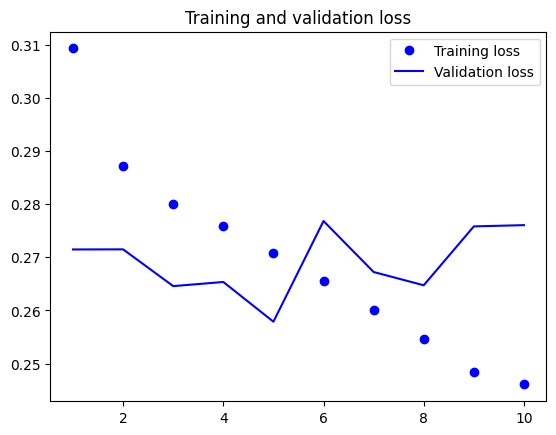

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 32)                4608      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4641 (18.13 KB)
Trainable params: 4641 (18.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training and evaluating a dropout-regularized GRU-based model

from keras.models import Sequential
from keras import layers
#from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.2,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=10,
                            validation_data=val_gen,
                            validation_steps=1000)

Epoch 1/10


<ipython-input-35-04a206b26396>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 93s 182ms/step - loss: 0.3225 - val_loss: 0.2846
Epoch 2/10
500/500 [==============================] - 92s 185ms/step - loss: 0.3059 - val_loss: 0.2836
Epoch 3/10
500/500 [==============================] - 93s 185ms/step - loss: 0.2997 - val_loss: 0.2782
Epoch 4/10
500/500 [==============================] - 94s 187ms/step - loss: 0.2955 - val_loss: 0.2719
Epoch 5/10
500/500 [==============================] - 93s 187ms/step - loss: 0.2889 - val_loss: 0.2751
Epoch 6/10
500/500 [==============================] - 91s 183ms/step - loss: 0.2851 - val_loss: 0.2754
Epoch 7/10
500/500 [==============================] - 93s 185ms/step - loss: 0.2807 - val_loss: 0.2857
Epoch 8/10
500/500 [==============================] - 93s 187ms/step - loss: 0.2766 - val_loss: 0.2747
Epoch 9/10
500/500 [==============================] - 91s 182ms/step - loss: 0.2722 - val_loss: 0.2839
Epoch 10/10
500/500 [==============================] - 90s 179ms/step - loss: 0.2690

Figure below shows the results. You’re no longer overfitting during the first 7 epochs but your best scores aren’t too different they were previously.

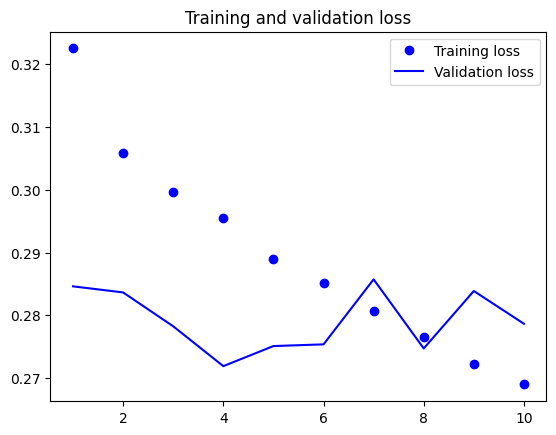

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Step 9. Stacking recurrent layers

Because you’re no longer overfitting but seem to have hit a performance bottleneck, you should consider increasing the capacity of the network.

Recall the description of the universal machine-learning workflow: it’s generally a good idea to increase the capacity of your network until overfitting becomes the primary obstacle (assuming you’re already taking basic steps to mitigate overfitting, such as using dropout). As long as you aren’t overfitting too badly, you’re likely under capacity.    

Increasing network capacity is typically done by increasing the number of units in the layers or adding more layers. Recurrent layer stacking is a classic way to build more-powerful recurrent networks: for instance, what currently powers the Google to translate algorithm is a stack of seven large LSTM layers—that’s huge.   

To stack recurrent layers on top of each other in Keras, all intermediate layers should return their full sequence of outputs (a 3D tensor) rather than their output at the last timestep. This is done by specifying return_sequences=True.

In [ ]:
from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(16,
                    dropout=0.1,
                    recurrent_dropout=0.2,
                    return_sequences=True,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.GRU(32, activation='relu',
                    dropout=0.1,
                    recurrent_dropout=0.2))
model.add(layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_3 (GRU)                 (None, None, 16)          1536      
                                                                 
 gru_4 (GRU)                 (None, 32)                4800      
                                                                 
 dense_8 (Dense)             (None, 1)                 33        
                                                                 
Total params: 6369 (24.88 KB)
Trainable params: 6369 (24.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                    steps_per_epoch=500,
                    epochs=10,
                    validation_data=val_gen,
                    validation_steps=1000)

Epoch 1/10


<ipython-input-39-c9b2b3fb033a>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 184s 360ms/step - loss: 0.3305 - val_loss: 0.2862
Epoch 2/10
500/500 [==============================] - 178s 357ms/step - loss: 0.3028 - val_loss: 0.2700
Epoch 3/10
500/500 [==============================] - 182s 364ms/step - loss: 0.2963 - val_loss: 0.2764
Epoch 4/10
500/500 [==============================] - 183s 366ms/step - loss: 0.2899 - val_loss: 0.2724
Epoch 5/10
500/500 [==============================] - 179s 359ms/step - loss: 0.2849 - val_loss: 0.2737
Epoch 6/10
500/500 [==============================] - 183s 365ms/step - loss: 0.2827 - val_loss: 0.2727
Epoch 7/10
500/500 [==============================] - 179s 358ms/step - loss: 0.2797 - val_loss: 0.2867
Epoch 8/10
500/500 [==============================] - 179s 359ms/step - loss: 0.2772 - val_loss: 0.2662
Epoch 9/10
500/500 [==============================] - 182s 363ms/step - loss: 0.2742 - val_loss: 0.2762
Epoch 10/10
500/500 [==============================] - 179s 359ms/step - lo

Figure below shows the results. You can see that the added layer does improve the results a bit, though not significantly. You can draw two conclusions:

* Because you’re still not overfitting too badly, you could safely increase the size of your layers in a quest for validation-loss improvement. This has a non-negligible computational cost, though.   

* Adding a layer didn’t help significantly, so you may see diminishing returns from increasing network capacity.    

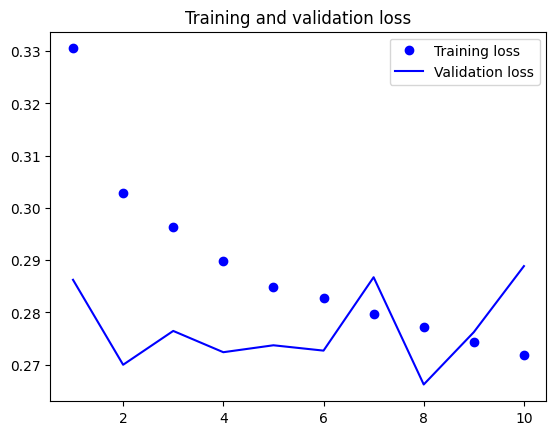

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Step 10. Go even further!
There are many other things you could try, in order to improve performance on the temperature-forecasting problem:
- Adjust the learning rate used by the RMSprop optimizer.
- Try using LSTM layer then a GRU layer then an LSTM layer again?
- Try using a bigger densely connected regressor on top of the recurrent layers: that is, a bigger Dense layer or even a stack of Dense layers.
- Don’t forget to eventually run the best-performing models (in terms of validation MAE) on the test set! Otherwise, you’ll develop architectures that are overfitting to the validation set.

Deep learning right now is still more like an art than a science. We can provide guidelines that suggest what is likely to work or not work on a given problem, but, ultimately, every problem is unique; you’ll have to evaluate different strategies empirically. There is currently no theory that will tell you in advance precisely what you should do to optimally solve a problem. You must iterate.

<div class="alert alert-block alert-success">

# Main Lessons

Here’s what you should take away:

* When approaching a new problem, it’s good first to establish common-sense baselines for your metric of choice. You can’t tell whether you’re making real progress if you don't have a baseline to beat.

* Try simple models before expensive ones to justify the additional expense. Sometimes a simple model will turn out to be your best option.

* When temporal ordering matters in data, recurrent networks are a great fit and easily outperform models that first flatten the temporal data.

* To use dropout with recurrent networks, you should use time-constant and recurrent dropout masks. These are built into Keras recurrent layers, so you only have to use the dropout and recurrent_dropout arguments of recurrent layers.

* Stacked RNNs provide more representational power than a single RNN layer. They’re also much more expensive and thus not always worth it. Although they offer clear gains on complex problems (such as machine translation), they may not always be relevant to smaller, simpler problems.

</div>

# Appendix A. Let's visualize the results
First, let's consider the dropout-regularized GRU-based model

In [ ]:
# Training and evaluating a dropout-regularized GRU-based model

from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.1,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                4608      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 4641 (18.13 KB)
Trainable params: 4641 (18.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Training and evaluating a dropout-regularized GRU-based model

from keras.models import Sequential
from keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.GRU(32,
                    dropout=0.2,
                    recurrent_dropout=0.1,
                    input_shape=(None, float_data.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                            steps_per_epoch=500,
                            epochs=5,
                            validation_data=val_gen,
                            validation_steps=1000)

Epoch 1/4


<ipython-input-16-26d50298c6df>:15: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_gen,


500/500 [==============================] - 90s 176ms/step - loss: 0.3231 - val_loss: 0.2782
Epoch 2/4
500/500 [==============================] - 89s 179ms/step - loss: 0.3057 - val_loss: 0.2723
Epoch 3/4
500/500 [==============================] - 88s 177ms/step - loss: 0.2994 - val_loss: 0.2861
Epoch 4/4
500/500 [==============================] - 90s 179ms/step - loss: 0.2936 - val_loss: 0.2682


For purpose of speed let's look at just the first 1000 training, validation and test data

In [ ]:
traing = []
for i in range(1000):
    traing.append(next(train_gen))

vg = []
for i in range(1000):
    vg.append(next(val_gen))

testg = []
for i in range(1000):
    testg.append(next(test_gen))

## Familiarizing with the inputs and outputs of the NN

In [ ]:
vg[0][0].shape #inputs sample_number or batch_size, input_timedelay, number_variables

(128, 240, 14)

In [ ]:
vg[999][0].shape #v[validation steps][input or target]

(128, 240, 14)

In [ ]:
vg[999][1].shape #target

(128,)

In [ ]:
float_data.shape  ## total lines with 14 parameters

(420551, 14)

In [ ]:
vg_pred1 = model.predict(vg[0][0]) #predict first 1280 minutes or 21.33 hours
vg_pred2= model.predict(vg[1][0]) #predict inputs of next 1280 mins
vg_pred3= model.predict(vg[2][0]) #predict inputs of next 1280* 3
vg_pred4= model.predict(vg[3][0]) #predict inputs of next 1280* 4
vg_pred5= model.predict(vg[4][0]) #predict inputs of next 1280* 5
vg_pred6= model.predict(vg[5][0]) #predict inputs of next 1280* 6
vg_pred10= model.predict(vg[9][0]) #predict inputs of next 1280* 9
vg_pred1000= model.predict(vg[999][0]) #predict inputs of next 1280* 1000

4/4 [==============================] - 0s 27ms/step


### Predict 21.33 hrs ~ 1 day

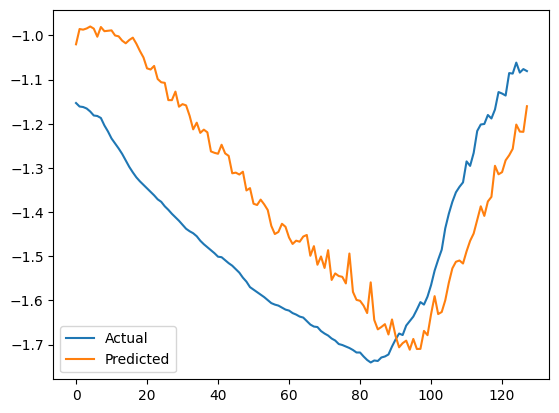

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

plt.plot(vg[1][1], label='Actual')
plt.plot(vg_pred2, label='Predicted')

plt.legend()
plt.show()

### Predict 21.33*2 hrs ~ 2 days

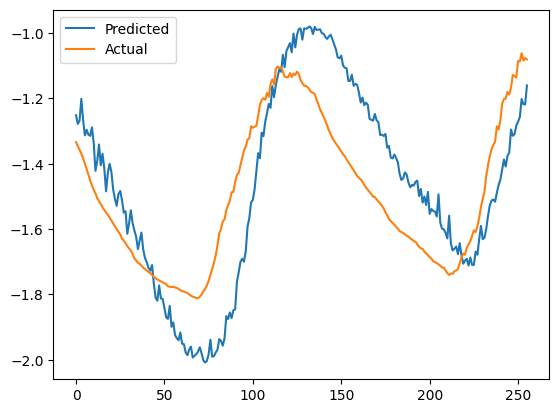

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(np.append(vg_pred1, vg_pred2), label='Predicted')  # Corrected label
plt.plot(np.append(vg[0][1], vg[1][1]), label='Actual')  # Corrected label

plt.legend()
plt.show()

### Predict 1280*10 minutes = 12800 minutes ~213.3 hrs ~ 8.9 days

In [ ]:
batches_considered = 10

preds = np.array([])
targets = np.array([])
for v in vg[:batches_considered]:
    preds = np.append(preds, model.predict(v[0]))
    targets = np.append(targets, v[1])

4/4 [==============================] - 0s 28ms/step


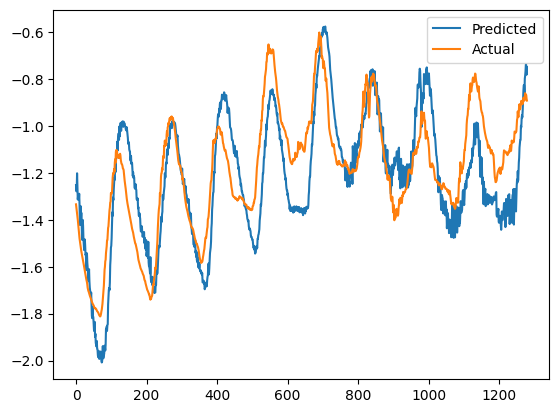

In [ ]:
plt.plot(preds, label='Predicted')
plt.plot(targets, label='Actual')

plt.legend()
plt.show()

<div class="alert alert-block alert-info">

## ⚠️ Checkpoint ⚠️

Do the same for the Test Set. What are your observations?
</div>

In [ ]:
batches_considered = 20

preds_test = np.array([])
targets_test = np.array([])
for v in testg[:batches_considered]:
    preds_test = np.append(preds_test, model.predict(v[0]))
    targets_test = np.append(targets_test, v[1])

4/4 [==============================] - 0s 26ms/step


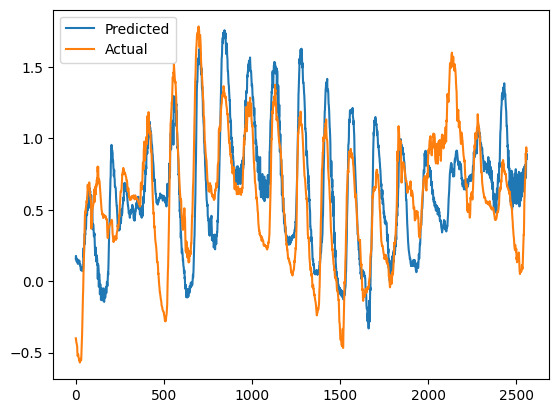

In [ ]:
plt.plot(preds_test, label='Predicted')
plt.plot(targets_test, label='Actual')
plt.legend()
plt.show()

4/4 [==============================] - 0s 26ms/step


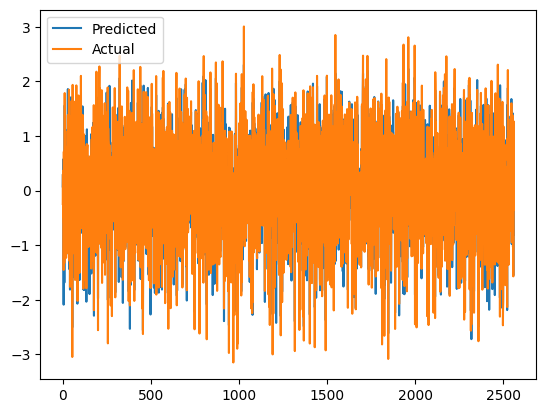

In [ ]:
batches_considered = 20

preds_train = np.array([])
targets_train = np.array([])
for v in traing[:batches_considered]:
    preds_train = np.append(preds_train, model.predict(v[0]))
    targets_train = np.append(targets_train, v[1])

plt.plot(preds_train, label='Predicted')
plt.plot(targets_train, label='Actual')

plt.legend()
plt.show()